# GETTING STARTED WITH KAGGLE COMPETITIONS
Author: *Melissa Liao*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will go through my first Kaggle competition project, the `Titanic - Machine Learning from Disaster`. In this project, we are going to follow the following workflow: 
1. Download and load the data given by the site: `train.csv` and `test.csv`.
2. Inspect the data to analyze any relationship between the features.
3. Preprocess any discrete, nominal and string data.
4. Fit and compare models using cross-validation (using our defined functions).
5. Apply hyperparameter tuning using grid search (using our defined functions) to find the best model.
6. Retrain best model on data and predict test data.
7. Submit predicted results to Kaggle and conclude my interpretations.
8. Reflect on this mini-project experience.

## 0. Function definitions

We will defined our own functions to make it easier to find the best model and hyperparameters that outputs the best accuracy scores for prediction.

In [2]:
from sklearn.model_selection import cross_validate

def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation
        
        
        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()
        
        returns: mean training score, mean validation score
    
    '''
    model.fit(X, y)
    scores = cross_validate(model, X, y, cv=cv, 
                            scoring=scoring, 
                            return_train_score=True)
    return scores['train_score'].mean(), scores['test_score'].mean()

In [3]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        
        scores are printed with 3 decimal places.
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        returns: None

    '''
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

In [4]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        uses mglearn.tools.heatmap() for plotting.
        
    '''
    results = pd.DataFrame(grid_search.cv_results_)
    params = sorted(grid_search.param_grid.keys())
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

## 1. Load data
The Titanic Kaggle project can be downloaded from https://www.kaggle.com/c/titanic/data and add it to your Jupyter Notebook directory.

In [5]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


A brief description of what each column represents:
* pclass - ticket class (1st, 2nd and 3rd class)
* Sex - gender
* Age - age in years
* SibSp - number of siblings and/or spouses aboard in the Titanic
* Parch - number of parents and/or children aboard in the Titanic
* Ticket - ticket number of the passenger
* Fare - passenger fare
* Cabin - cabin number
* Embarked - port of embarkation (C=Cherbourg, Q=Queenstown, S=Southampton)

### 1.1 Prepare the feature matrix and target vector

Since the test data doesn't include the ground truth on passengers who survived in the Titanic, we will only set the train data into feature matrix `X` and target vector `y`. And print out the shape and type of `X`, `y`. As we know what each information represents, I would discard the `PassengerId`, `Name` and `Ticket` columns. All three columns contains unique values on each row that pertains to the actual passenger identification and it wouldn't be relevant for the objective of the project. Also, the port of embarkation from a passenger, `Embarked`, doesn't directly impact from the place where the incident occur, so we may take that column as well.

In [7]:
train_data = train_data.drop(['PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,0,3,male,22.0,1,0,7.2500,NaN
1,1,1,female,38.0,1,0,71.2833,C85
2,1,3,female,26.0,0,0,7.9250,NaN
3,1,1,female,35.0,1,0,53.1000,C123
4,0,3,male,35.0,0,0,8.0500,NaN


In [8]:
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

print('X.shape={}, type(X)={}'.format(X_train.shape, type(X_train)))
print('y.shape={}, type(y)={}'.format(y_train.shape, type(y_train)))

X.shape=(891, 7), type(X)=<class 'pandas.core.frame.DataFrame'>
y.shape=(891,), type(y)=<class 'pandas.core.series.Series'>


In [9]:
X_test = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Embarked'], axis=1)
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,3,male,34.5,0,0,7.8292,NaN
1,3,female,47.0,1,0,7.0000,NaN
2,2,male,62.0,0,0,9.6875,NaN
3,3,male,27.0,0,0,8.6625,NaN
4,3,female,22.0,1,1,12.2875,NaN


In [10]:
print('X_test.shape={}, type(X_test)={}'.format(X_test.shape, type(X_test)))

X_test.shape=(418, 7), type(X_test)=<class 'pandas.core.frame.DataFrame'>


## 2. Inspect the data 

### 2.1 Get information on data types and check for missing values (NaN)

Let's try to get a general idea of what our data values are composed of and see if there are any missing values. This part is important as missing values could affect when we try to preprocess and encode the data to be fit our model.

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    object 
 2   Age     714 non-null    float64
 3   SibSp   891 non-null    int64  
 4   Parch   891 non-null    int64  
 5   Fare    891 non-null    float64
 6   Cabin   204 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    object 
 2   Age     332 non-null    float64
 3   SibSp   418 non-null    int64  
 4   Parch   418 non-null    int64  
 5   Fare    417 non-null    float64
 6   Cabin   91 non-null     object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


As we can see above, there are some features that has missing values within our train and test data, i.e. `Age`,`Cabin` and `Fare`. We can get the rate percentage of null values of these features and decide whether to include it in our feature matrix.

In [13]:
(X_train.isnull().sum() / X_train.shape[0]) * 100

Pclass     0.000000
Sex        0.000000
Age       19.865320
SibSp      0.000000
Parch      0.000000
Fare       0.000000
Cabin     77.104377
dtype: float64

In [14]:
(X_test.isnull().sum() / X_test.shape[0]) * 100

Pclass     0.000000
Sex        0.000000
Age       20.574163
SibSp      0.000000
Parch      0.000000
Fare       0.239234
Cabin     78.229665
dtype: float64

Since the `Cabin` and `Age` columns has a bit over 77% and over 19% of null values, respectively, it is best to disregard them for our model. The percentage of missing values could potentially skew and affect the prediction results if it's included.

For the `Fare` column, there's only one row with a missing value. In this case, we could fill out the missing value with the average passenger fare.

In [15]:
X_train = X_train.drop(['Age','Cabin'], axis=1)
print('X.shape={}, type(X)={}'.format(X_train.shape, type(X_train)))

X.shape=(891, 5), type(X)=<class 'pandas.core.frame.DataFrame'>


In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    object 
 2   SibSp   891 non-null    int64  
 3   Parch   891 non-null    int64  
 4   Fare    891 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 34.9+ KB


Apply the same process and inspect `X_test` data.

In [17]:
X_test = X_test.fillna(X_test.mean())

In [18]:
X_test = X_test.drop(['Age','Cabin'], axis=1)
print('X_test.shape={}, type(X_test)={}'.format(X_test.shape, type(X_test)))

X_test.shape=(418, 5), type(X_test)=<class 'pandas.core.frame.DataFrame'>


In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  418 non-null    int64  
 1   Sex     418 non-null    object 
 2   SibSp   418 non-null    int64  
 3   Parch   418 non-null    int64  
 4   Fare    418 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 16.5+ KB


### 2.2 Relationship between features and target classes

Now let's try to understand the relationship between categorical features and target classes better. It is useful to visualize our features in barplots for each target class. Using seaborn `countplot()`, produce a barplot for each of the five feature columns in `X_train` using  `y_train` as hue.

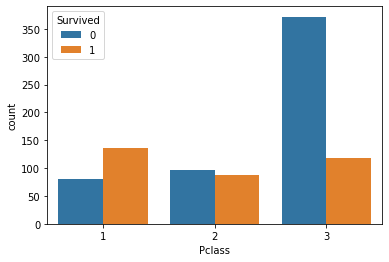

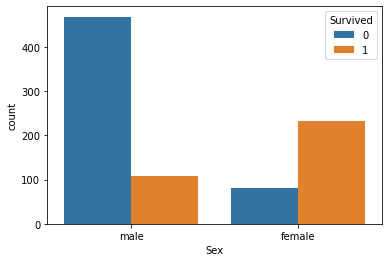

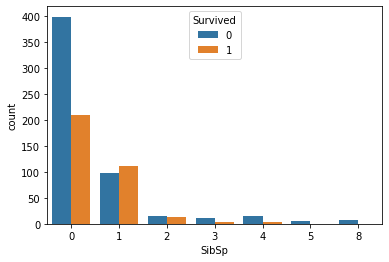

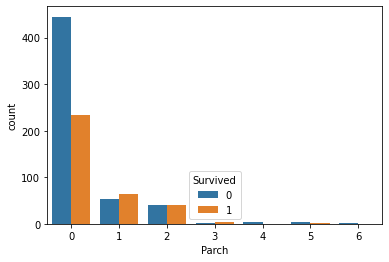

In [20]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch']

for i in features:
    sns.countplot(x=X_train[i], hue=y_train);
    plt.show()

From the barplots, it can tell us a lot on how each category from each feature could affect the chances of survival. Passengers from higher class are most likely to survive. Females and passengers with 1-2 family relatives as well.